In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inverter-data-set/Inverter Data Set.csv


# The use of neural networks for the identification of a mechatronic system : DC MOTOR


# Realised by : Rymeh LASSOUED
We aim to employ neural networks to identify and model the behavior of a DC motor system. Through the collection and analysis of experimental data, the neural network will be trained to predict the dynamic response of the motor to different input conditions.

# Data Collection : 

The data set comprises several sensor data collected from a typical combined system between an inverter, an induction motor, and a control system, deployed on a test bench. Test bench measurements were collected by :

the LEA department at Paderborn University.

An inverter is a power electronic component with transistors (read 'switches'), that determine how the battery voltage (so called DC-link voltage) is applied on the three phase circuits of the electric motor. The control unit decides according to some control strategy the current switching states of the inverter at each discrete point in time.






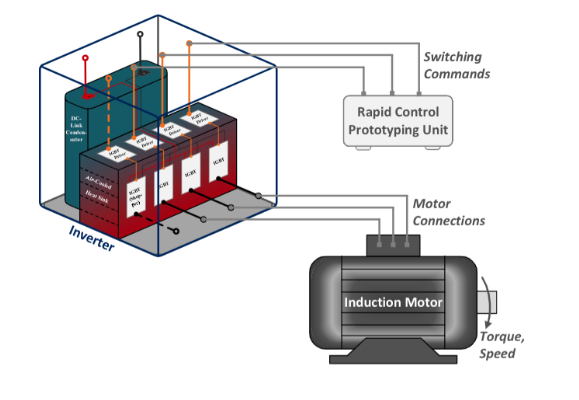 




The data set comprises approximately 235 thousand samples in the complete operating range of an exemplary drive system.

Rows follow no particular order.

# Detailed description

A comprehensive description of the data set can be found in the following paper (freely available):

https://www.researchgate.net/publication/343480544_Data_Set_Description_Three-Phase_IGBT_Two-Level_Inverter_for_Electrical_Drives

Links : 
Department of Power Electronics and Electrical Drives, Paderborn University, Germany : 
https://ei.uni-paderborn.de/en/lea/




# Defining the Inputs/Outputs of the motor rotation:

#  Input Variables:

* Voltage Applied (u_dc_k):

Description: This variable represents the voltage supplied to the DC motor. It directly affects the motor's speed and torque characteristics.
Units: Volts (V).
Importance: The voltage applied to the motor determines its operating conditions. Higher voltages generally result in higher motor speeds and increased torque.

* DC Motor Voltage History (u_dc_k-1, u_dc_k-2, u_dc_k-3):

Description: These variables represent the history of the DC Motor voltage, with u_dc_k-1 representing the voltage one sampling step before, u_dc_k-2 representing the voltage two sampling steps before, and u_dc_k-3 representing the voltage three sampling steps before.
Units: Volts (V).
Importance: The history of the DC-link voltage provides insight into the past behavior of the motor system, which can influence its current state and future response. Understanding how the voltage has changed over time can help in predicting the motor's behavior and response to different input conditions.

* Phase Currents (i_a_k, i_b_k, i_c_k, i_a_k-1, i_b_k-1):

Description: These variables represent the phase currents of phases a, b, and c of the motor, with i_a_k, i_b_k, and i_c_k representing the currents at the current sampling step, and i_a_k-1 and i_b_k-1 representing the currents one sampling step before.
Units: Amperes (A).
Importance: Phase currents are crucial for understanding the load on the motor and its electrical characteristics. They directly affect the motor's torque production and efficiency. Monitoring phase currents helps in detecting abnormalities and optimizing motor performance.

#  Output Variables:
* Motor Speed (n_k):

Description: Motor speed represents the rotational speed of the DC motor's shaft, typically measured in revolutions per minute (RPM) or radians per second (rad/s).
Units: RPM or rad/s.
Importance: Motor speed is a critical output variable as it directly reflects the performance and behavior of the DC motor system. It is influenced by the applied voltage, torque, and motor parameters. Predicting motor speed accurately is essential for optimizing motor performance and control strategies.

# By defining these input and output variables, the project aims to utilize neural networks to identify and model the behavior of the DC motor system. Through the collection and analysis of experimental data, the neural network will be trained to predict the dynamic response of the motor to different input conditions, leading to improved control, efficiency, and performance.







# Importing Libraries


In [22]:
# TensorFlow, google machine learning library
import tensorflow as tf
# Neural networks library
from tensorflow import keras
# database management library
import pandas as pd
# linear algebra library
import numpy as np
# plot library
import matplotlib.pyplot as plt
# scientific math library
import scipy.io
# machine learning library
import sklearn as skl
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
# pseudo-random numbers library
import random
# library for correlation map
import seaborn as sns
#
import matplotlib.pyplot as plt


2024-04-17 01:28:50.936245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 01:28:50.936393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 01:28:51.113132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We fix the random seed in order to allow repeatability

In [23]:
random.seed(10)

# Loading the dataset : 

In [26]:
data_raw=pd.read_csv('../input/inverter-data-set/Inverter Data Set.csv')
data_raw.head(10)

,n_k,u_dc_k,u_dc_k-1,u_dc_k-2,u_dc_k-3,i_a_k,i_b_k,i_c_k,i_a_k-1,i_b_k-1,...,i_c_k-3,d_a_k-2,d_b_k-2,d_c_k-2,d_a_k-3,d_b_k-3,d_c_k-3,u_a_k-1,u_b_k-1,u_c_k-1
0,3001.406296,567.985297,567.689956,567.431534,567.948379,2.461991,-1.792057,-0.716639,2.729208,-2.098439,...,-0.613965,0.667181,0.874633,0.125367,0.706206,0.862754,0.137246,360.541201,510.640963,82.471117
1,3001.468250,567.911462,567.985297,567.689956,567.431534,2.292110,-1.556948,-0.757338,2.461991,-1.792057,...,-0.758263,0.642184,0.880046,0.119954,0.667181,0.874633,0.125367,346.410081,513.190083,79.729357
2,3001.527815,567.911462,567.911462,567.985297,567.689956,2.155288,-1.332946,-0.840587,2.292110,-1.556948,...,-0.698139,0.611911,0.884307,0.115693,0.642184,0.880046,0.119954,329.440240,515.804643,77.924637
3,3001.585080,567.653039,567.911462,567.911462,567.985297,2.048768,-1.135788,-0.925686,2.155288,-1.332946,...,-0.716639,0.578149,0.888915,0.111085,0.611911,0.884307,0.115693,311.058880,517.537603,75.478717
4,3001.640131,567.579204,567.653039,567.911462,567.911462,1.952350,-0.918266,-1.027434,2.048768,-1.135788,...,-0.757338,0.541979,0.892123,0.107877,0.578149,0.888915,0.111085,290.481760,519.138403,73.580077
5,3001.693049,567.579204,567.579204,567.653039,567.911462,1.863278,-0.710000,-1.137507,1.952350,-0.918266,...,-0.840587,0.504439,0.894707,0.105293,0.541979,0.892123,0.107877,268.514480,519.268483,72.567117
6,3001.752952,567.689956,567.579204,567.579204,567.653039,1.767777,-0.498957,-1.276255,1.863278,-0.710000,...,-0.925686,0.465802,0.895410,0.104590,0.504439,0.894707,0.105293,247.132399,518.989763,72.276637
7,3001.873562,567.505369,567.689956,567.579204,567.579204,1.690643,-0.261997,-1.414078,1.767777,-0.498957,...,-1.027434,0.426395,0.894788,0.105212,0.465802,0.895410,0.104590,224.485519,517.429603,73.144157
8,3001.996791,567.653039,567.505369,567.689956,567.579204,1.613508,-0.060210,-1.554676,1.690643,-0.261997,...,-1.137507,0.386276,0.892363,0.107637,0.426395,0.894788,0.105212,202.544479,512.005363,74.859917
9,3002.113320,567.874544,567.653039,567.505369,567.689956,1.545556,0.116585,-1.677699,1.613508,-0.060210,...,-1.276255,0.345641,0.888466,0.111534,0.386276,0.892363,0.107637,179.174158,503.316483,77.297437


# Describes the variables present in the dataset


In [27]:
data_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234527 entries, 0 to 234526
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   n_k       234527 non-null  float64
 1   u_dc_k    234527 non-null  float64
 2   u_dc_k-1  234527 non-null  float64
 3   u_dc_k-2  234527 non-null  float64
 4   u_dc_k-3  234527 non-null  float64
 5   i_a_k     234527 non-null  float64
 6   i_b_k     234527 non-null  float64
 7   i_c_k     234527 non-null  float64
 8   i_a_k-1   234527 non-null  float64
 9   i_b_k-1   234527 non-null  float64
 10  i_c_k-1   234527 non-null  float64
 11  i_a_k-2   234527 non-null  float64
 12  i_b_k-2   234527 non-null  float64
 13  i_c_k-2   234527 non-null  float64
 14  i_a_k-3   234527 non-null  float64
 15  i_b_k-3   234527 non-null  float64
 16  i_c_k-3   234527 non-null  float64
 17  d_a_k-2   234527 non-null  float64
 18  d_b_k-2   234527 non-null  float64
 19  d_c_k-2   234527 non-null  float64
 20  d_a_

# Histograms have been drawn in order to see if all the variables fall in a physical reliable range.



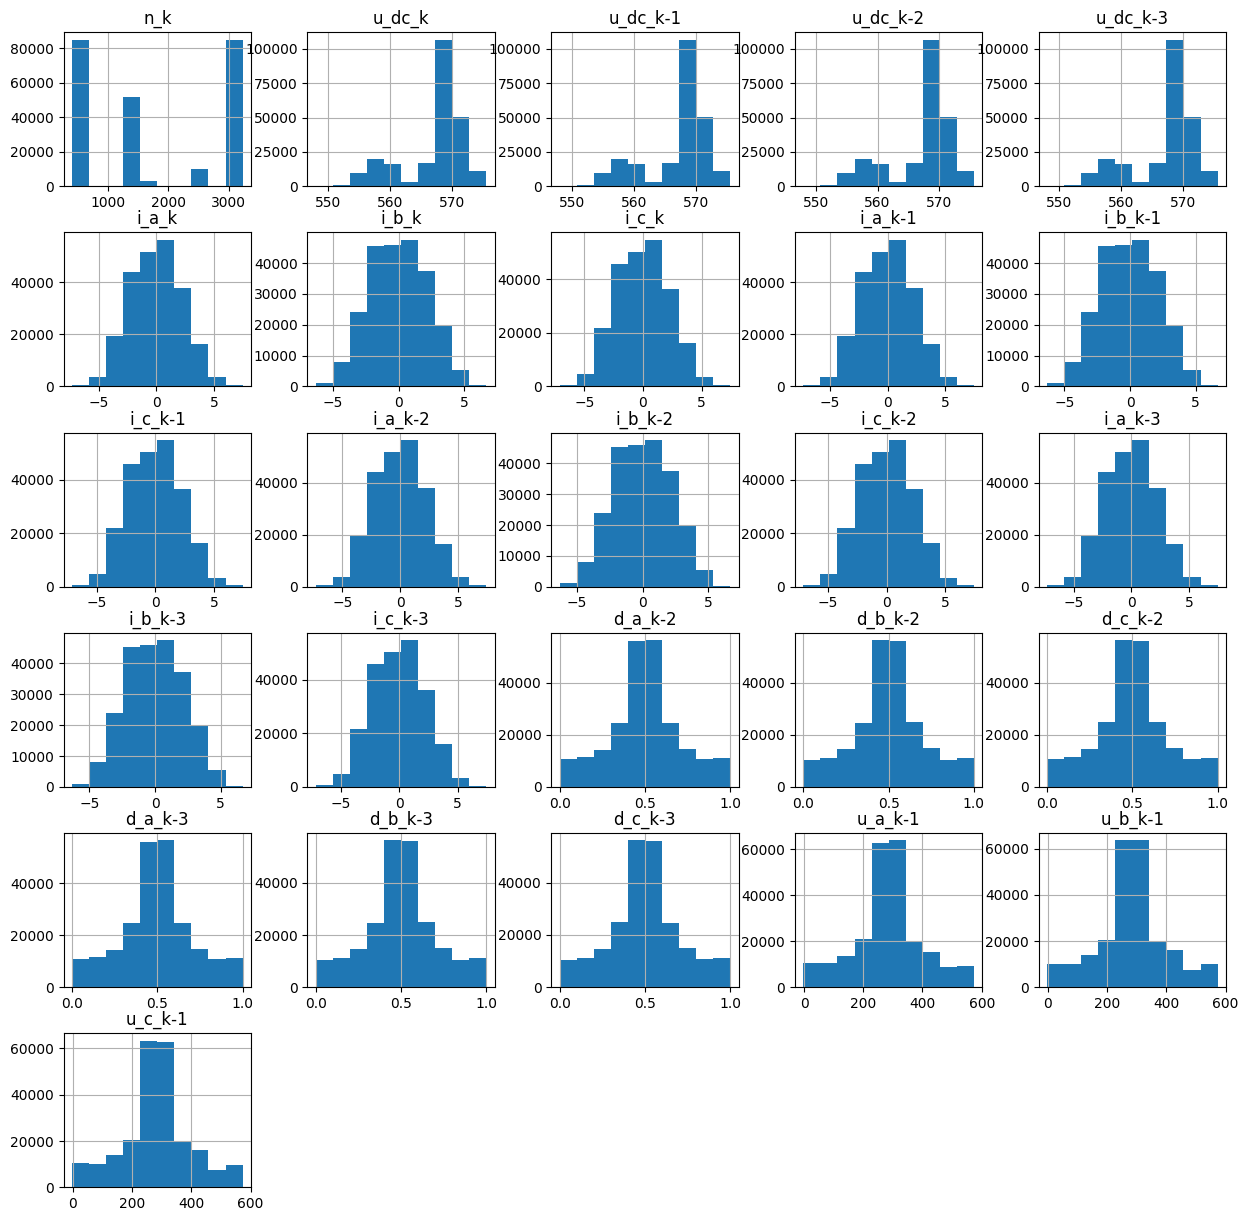

In [28]:
data_raw.hist(figsize=(15,15));

# Describes the main features of our data


In [29]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
n_k,234527.0,1728.414990,1084.463934,404.433935,507.572918,1501.516456,2996.851500,3231.756077
u_dc_k,234527.0,567.136398,4.993615,548.012908,566.730100,568.649812,570.126514,575.553392
u_dc_k-1,234527.0,567.136565,4.993462,548.012908,566.730100,568.649812,570.126514,575.553392
u_dc_k-2,234527.0,567.136718,4.993317,548.012908,566.730100,568.649812,570.126514,575.553392
u_dc_k-3,234527.0,567.136882,4.993180,548.012908,566.730100,568.649812,570.126514,575.553392
i_a_k,234527.0,0.000505,2.199349,-7.300153,-1.573353,0.023062,1.552902,7.470243
i_b_k,234527.0,-0.007692,2.155399,-6.320221,-1.576386,0.000881,1.557785,6.668168
i_c_k,234527.0,-0.008975,2.216263,-7.112914,-1.591675,0.010400,1.566225,7.437108
i_a_k-1,234527.0,0.000518,2.199206,-7.300153,-1.572894,0.023062,1.552902,7.470243
i_b_k-1,234527.0,-0.007737,2.155302,-6.320221,-1.576386,0.000881,1.557785,6.668168


# Check if there are null values

In [30]:
data_raw.isnull().values.any()


False

# Some plots have been done in order to visualize the quantities with which we are dealing.



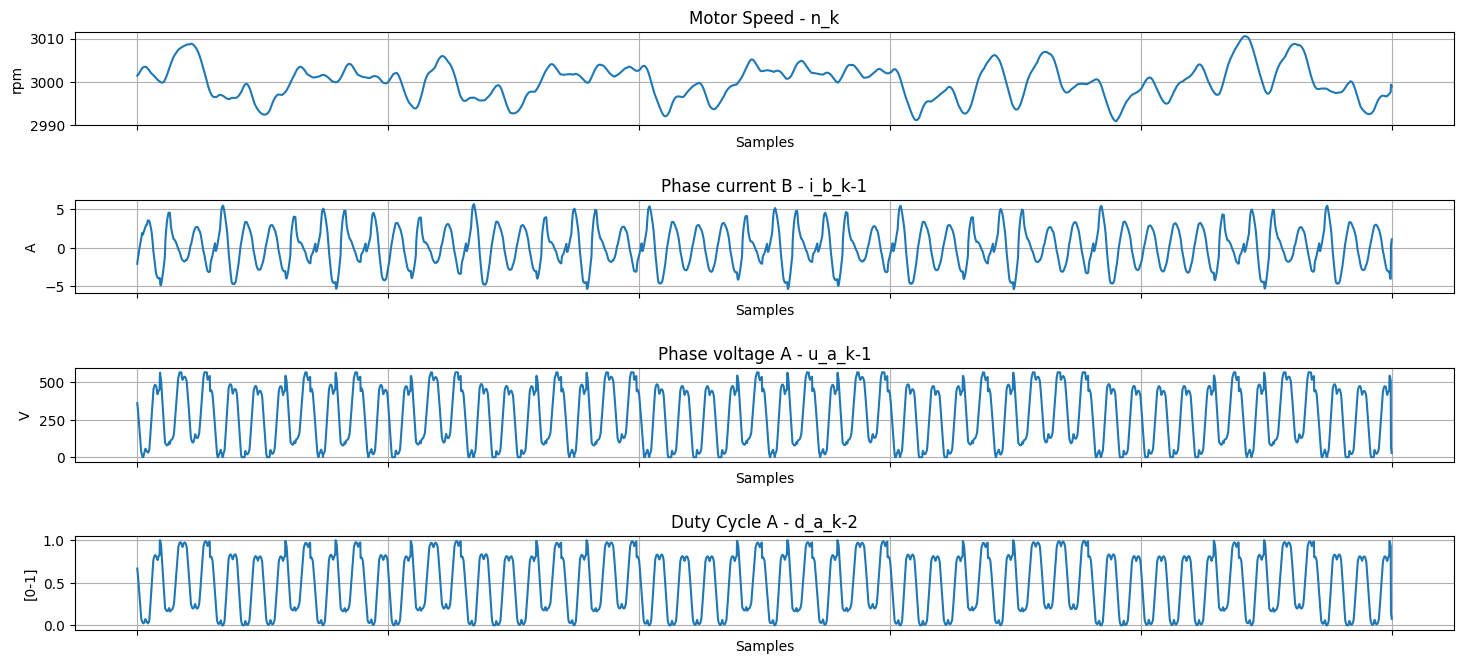

In [42]:
p_sample= 5000

col_iak1=data_raw['n_k'].head(p_sample)
p_iak1 = plt.subplot(4,1,1)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Motor Speed - n_k')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('rpm')

col_iak1=data_raw['i_b_k-1'].head(p_sample)
p_iak1 = plt.subplot(4,1,2)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Phase current B - i_b_k-1')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('A')

col_iak1=data_raw['u_a_k-1'].head(p_sample)
p_iak1 = plt.subplot(4,1,3)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Phase voltage A - u_a_k-1')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('V')

col_iak1=data_raw['d_a_k-2'].head(p_sample)
p_iak1 = plt.subplot(4,1,4)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Duty Cycle A - d_a_k-2')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('[0-1]')

plt.tight_layout(pad=2.0)

# Correlation matrix


In [32]:
data_raw.corr()


,n_k,u_dc_k,u_dc_k-1,u_dc_k-2,u_dc_k-3,i_a_k,i_b_k,i_c_k,i_a_k-1,i_b_k-1,...,i_c_k-3,d_a_k-2,d_b_k-2,d_c_k-2,d_a_k-3,d_b_k-3,d_c_k-3,u_a_k-1,u_b_k-1,u_c_k-1
n_k,1.000000,-0.428551,-0.428544,-0.428539,-0.428535,0.000976,0.004075,0.003156,0.000992,0.004068,...,0.003129,0.000401,0.002339,0.002103,0.000409,0.002361,0.002084,-0.012105,-0.010189,-0.010992
u_dc_k,-0.428551,1.000000,0.997913,0.995965,0.993376,-0.006246,-0.002922,0.001044,-0.006376,-0.002761,...,0.001014,-0.004242,-0.007184,-0.006002,-0.004491,-0.007542,-0.006160,0.020417,0.017191,0.019000
u_dc_k-1,-0.428544,0.997913,1.000000,0.997913,0.995965,-0.006257,-0.002985,0.001125,-0.006325,-0.002871,...,0.001044,-0.004099,-0.006936,-0.005845,-0.004279,-0.007226,-0.005933,0.020601,0.017474,0.019218
u_dc_k-2,-0.428539,0.995965,0.997913,1.000000,0.997913,-0.006239,-0.003082,0.001196,-0.006334,-0.002937,...,0.001087,-0.004000,-0.006716,-0.005720,-0.004135,-0.006979,-0.005777,0.020713,0.017721,0.019377
u_dc_k-3,-0.428535,0.993376,0.995965,0.997913,1.000000,-0.006220,-0.003179,0.001260,-0.006322,-0.003034,...,0.001124,-0.003913,-0.006529,-0.005625,-0.004039,-0.006762,-0.005647,0.020793,0.017902,0.019476
i_a_k,0.000976,-0.006246,-0.006257,-0.006239,-0.006220,1.000000,-0.481779,-0.524303,0.998620,-0.517190,...,-0.413571,0.465385,0.327131,-0.785642,0.500605,0.287640,-0.783464,0.375554,0.395191,-0.763603
i_b_k,0.004075,-0.002922,-0.002985,-0.003082,-0.003179,-0.481779,1.000000,-0.493433,-0.444973,0.998566,...,-0.594599,-0.796127,0.487990,0.328403,-0.792778,0.523621,0.288071,-0.776911,0.398484,0.395154
i_c_k,0.003156,0.001044,0.001125,0.001196,0.001260,-0.524303,-0.493433,1.000000,-0.558727,-0.456837,...,0.988167,0.311639,-0.800406,0.462645,0.273236,-0.795780,0.499664,0.381857,-0.781295,0.375726
i_a_k-1,0.000992,-0.006376,-0.006325,-0.006334,-0.006322,0.998620,-0.444973,-0.558727,1.000000,-0.481756,...,-0.451505,0.428608,0.365535,-0.785042,0.465333,0.327124,-0.785621,0.337213,0.431479,-0.759405
i_b_k-1,0.004068,-0.002761,-0.002871,-0.002937,-0.003034,-0.517190,0.998566,-0.456837,-0.481756,1.000000,...,-0.562438,-0.796770,0.450686,0.367540,-0.796138,0.488020,0.328405,-0.773716,0.359517,0.432227


# Correlation Heatmap
A correlation map has been created in order to evaluate the correlation between the different predictors and highlight the ones with highest relevance. We initially worked on building the training/test sets by using the whole predictors data and subsequently removing the predictors with lower correlation, measuring the difference in terms of accuracy.

The map shows the followings:

* The motor speed (n_k) is correlated with dc voltages only (u_dc) and viceversa;
* Almost no correlation is found between motor speed and dc voltages with phase currents (a,b,c) and phase voltages (a,b,c);
* Phase currents (a,b,c) are correlated with duty cycles


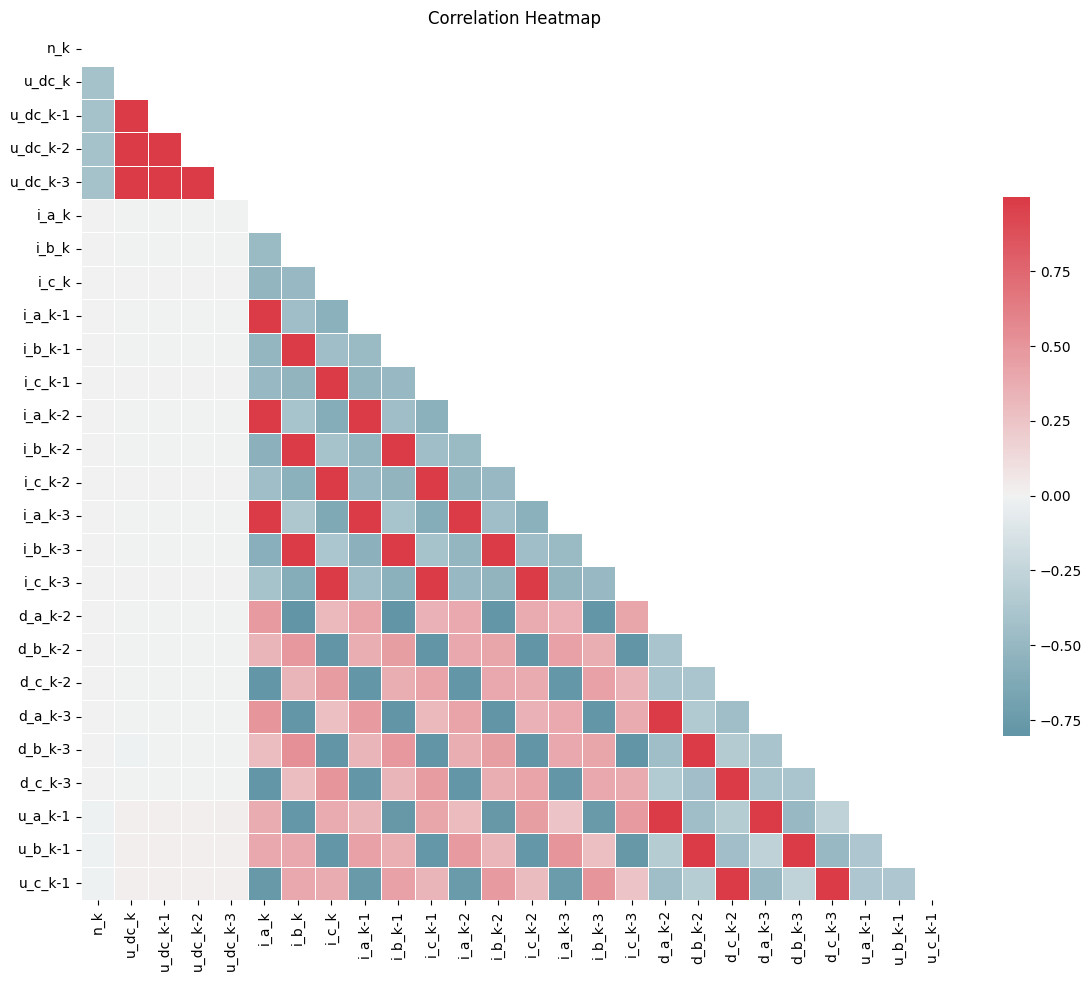

In [35]:
#correlation map
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data_raw is your DataFrame containing the dataset

# Calculate the correlation matrix
corr = data_raw.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()


With the following plot we can visualize the correlation. The most correlated variables show variables close to the bisector while uncorrelated variables show chaotic patterns.



# Data Cutting

In [37]:
dfx1 = data_raw[['n_k','u_dc_k','u_dc_k-1','u_dc_k-2','u_dc_k-3','i_a_k','i_a_k-1',
                 'i_a_k-2','i_a_k-3','i_b_k','i_b_k-1','i_b_k-2','i_b_k-3','i_c_k',
                 'i_c_k-1','i_c_k-2','i_c_k-3','d_a_k-2','d_a_k-3','d_b_k-2','d_b_k-3',
                 'd_c_k-2','d_c_k-3']]
#dfy1 = data_raw[['u_a_k-1','u_b_k-1','u_c_k-1']]
dfy1 = data_raw['u_a_k-1']


# Data standardization : 
In order to have all the input variables on the same scale we perform standardization. This is fundamental for algorithms that use weights for assuring that each variable contributes equally.

In our case k-nearest neighbours and artificial neural network must use standardized input variables. Tree based algorithms (in our case decision tree, pruning and random forest) are insensitive to this problem since they classify based on punctual values and do not make any weighted operation.



In [45]:
scaler = preprocessing.StandardScaler()
scaler.fit(dfx1)
dfx1=scaler.transform(dfx1)
dfx1 = pd.DataFrame(dfx1)


The plot below is showing the motor speed before and after the standardization.

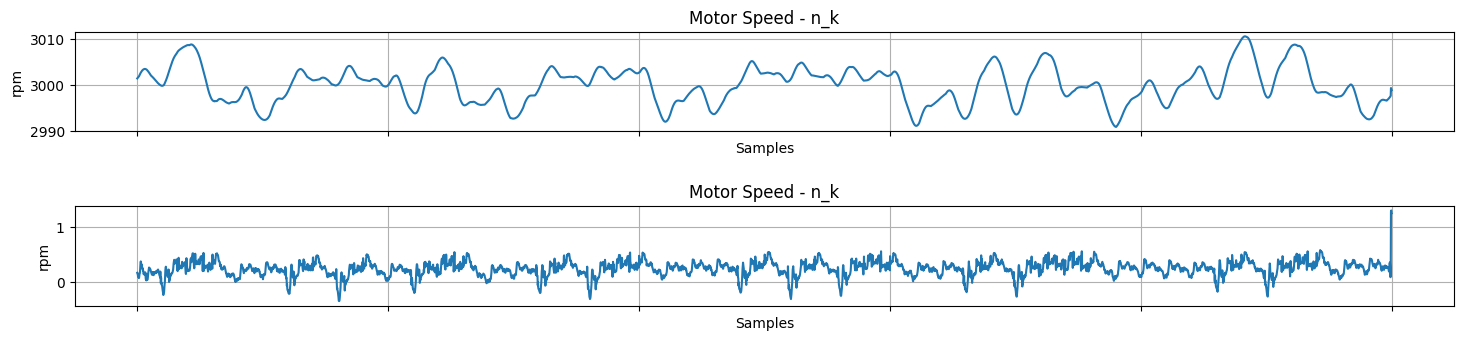

In [46]:
p_sample= 5000

col_iak1=data_raw['n_k'].head(p_sample)
p_iak1 = plt.subplot(4,1,1)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Motor Speed - n_k')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('rpm')

col_iak1=dfx1[1].head(p_sample)
p_iak1 = plt.subplot(4,1,2)
col_iak1.plot(use_index = True, figsize = (15,7))
plt.setp(p_iak1.get_xticklabels(), visible=False)
plt.title('Motor Speed - n_k')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('rpm')

plt.tight_layout(pad=2.0)


# Score parameters used :

* MSE (Mean Square Error): it indicates the averaged squared difference between estimated data and observed data.

* RMSE (Root Mean Square Error): it is the sqaured root of the mse.

* MAE (Mean absolute error): it is the average of the difference between estimated and observed data.

* R2 (coefficient of determination): it is the ratio between the deviance of the predicted data and the one of the real data. The closer to 1 the more accurate is the model.



# Choice of neural network architecture:

# ANN - Artificial Neural Network
Artificial Neural Networks are one of the main branches in the machine learning field. They are computational systems that try to replicate the structure of biological neural networks. The main unit is the node (N), which communictes through links (L), with other nodes; the system is a dimensional space where N >> L. The nodes are organized in layers.

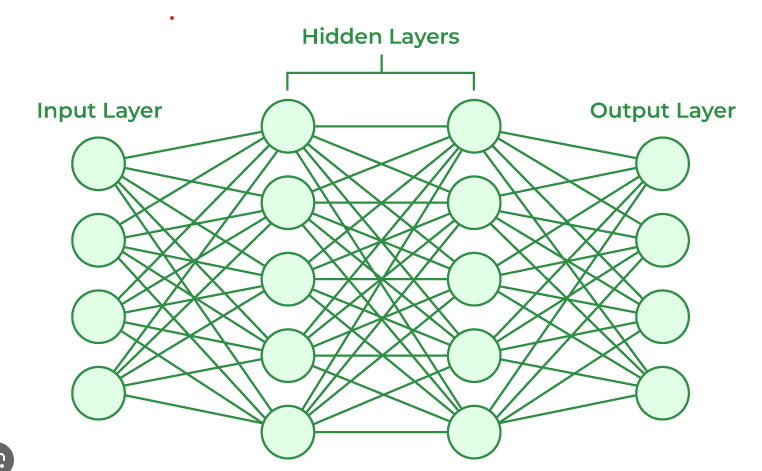

The basic structure includes: • An input layer, which receives the inputs to be processed by the system; • One or more intermediate layers (also called hidden); • A final layer that provides the outputs.

The neuron is made up of three fundamental elements:

* A variable number of connections characterized by weights;
* An adder, which sums the inputs from the various connections based on their weight, producing as output a linear combination of the received inputs;
An activation function that serves to limit the value of the output. Usually the output is between the values ​​[0,1] or [-1,1].
* There are several activation functions, the most used are the sigmoid and the ReLu (Rectified Linear Unit).

The neural network training can be done in two different ways: supervised (when the output as well as the input is known) and unsupervised(when only inputs are known).

The error signal activates a self-checking procedure of the system through a series of adjustments of the weight of each connection of the k-th neuron with the aim of reducing the difference between the response generated and the expected response.

# 1) Layer Architecture : 

In order to understand which is the optimal number of neurons, we started using only one layer and we varied the number of neurons [5,10,15,20,50]. ReLu were used as activation functions in the hidden layer while linear function was used for the output layer (since output values are unbounded). The epochs were fixed to 150, monitoring the output residuals it was seen that the mean squared error converged to a constant value without significant improvements.



# Determine how many neurons are needed with one layer


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfx1, dfy1, test_size=0.25, shuffle=False)

k=1

neuron_Arr=[5,10,15,20,50]

ann_avg_mse_train=[]
ann_avg_rmse_train=[]
ann_avg_r2_train=[]
ann_avg_mape_train=[]

ann_avg_mse_test=[]
ann_avg_rmse_test=[]
ann_avg_r2_test=[]
ann_avg_mape_test=[]

for neuron in neuron_Arr:

      ANN = keras.Sequential([
          keras.layers.Flatten(input_shape=(23,)),  # input layer (1)
          keras.layers.Dense(neuron, activation='relu'),  # hidden layer (2)
          keras.layers.Dense(1, activation='linear') # output layer (3)
      ])


      ANN.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())
      keras.callbacks.EarlyStopping(monitor='loss',
                                    min_delta=0.1,
                                    patience=3,
                                    verbose=1, mode='auto')

      mse_score_train = []
      rmse_score_train = []
      r2_score_train = []
      mape_score_train = []

      mse_score_test = []
      rmse_score_test = []
      r2_score_test = []
      mape_score_test = []
             
          
      ANN.fit(X_train,y_train,epochs=150,shuffle=False)
      y_pred_train = ANN.predict(X_train)
      y_pred_test = ANN.predict(X_test)
      

      mse_train = metrics.mean_squared_error(y_train, y_pred_train)
      mse_score_train.append(mse_train)
      rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
      rmse_score_train.append(rmse_train)
      r2_train = r2_score(y_train, y_pred_train)
      r2_score_train.append(r2_train)
      mape_train = metrics.mean_absolute_error(y_train, y_pred_train)
      mape_score_train.append(mape_train)

      mse_test = metrics.mean_squared_error(y_test, y_pred_test)
      mse_score_test.append(mse_test)
      rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
      rmse_score_test.append(rmse_test)
      r2_test = r2_score(y_test, y_pred_test)
      r2_score_test.append(r2_test)
      mape_test = metrics.mean_absolute_error(y_test, y_pred_test)
      mape_score_test.append(mape_test)
          
      ann_avg_mse_train.append(sum(mse_score_train)/k)
      ann_avg_rmse_train.append(sum(rmse_score_train)/k)
      ann_avg_r2_train.append(sum(r2_score_train)/k)
      ann_avg_mape_train.append(sum(mape_score_train)/k)

      ann_avg_mse_test.append(sum(mse_score_test)/k)
      ann_avg_rmse_test.append(sum(rmse_score_test)/k)
      ann_avg_r2_test.append(sum(r2_score_test)/k)

      ann_avg_mape_test.append(sum(mape_score_test)/k)


Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5497/5497 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 78695.7969
Epoch 2/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 10815.6133
Epoch 3/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 8185.4902
Epoch 4/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4655.7891
Epoch 5/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 2767.6980
Epoch 6/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1710.9191
Epoch 7/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1099.6058
Epoch 8/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 742.0706
Epoch 9/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 545.5327
Epoch 10/150
5497/5497 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 420.3731
Epoch 11/150


In [ ]:
print("Results with single hidden layer and with", neuron_Arr, "neurons")

print("TRAINING")
print("Mean Squared Error:",np.around(np.array(ann_avg_mse_train),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_train),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_train),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_train),2))

print("TEST")
print("Mean Squared Error:", np.around(np.array(ann_avg_mse_test),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_test),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_test),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_test),2))


The lowest errors were obtained with 15 neurons.

# Trying with 3 Hidden Layers
A further analysis with 3 layers has been done with the purpose of understanding if the errors could decrease.


In [ ]:
#Determine how many neurons are needed with 3 layers
#avoiding k-fold
X_train, X_test, y_train, y_test = train_test_split(dfx1, dfy1, test_size=0.25, shuffle=False)
#k=2 to avoid modification to the code with the k-fold
k=1

neuron_Arr=[5,10,15,20,50]

ann_avg_mse_train=[]
ann_avg_rmse_train=[]
ann_avg_r2_train=[]
ann_avg_mape_train=[]

ann_avg_mse_test=[]
ann_avg_rmse_test=[]
ann_avg_r2_test=[]
ann_avg_mape_test=[]

for neuron in neuron_Arr:

          ANN = keras.Sequential([
              keras.layers.Flatten(input_shape=(23,)),  # input layer (1)
              keras.layers.Dense(neuron, activation='relu'),  # hidden layer (2)
              keras.layers.Dense(neuron, activation='relu'),  # hidden layer (3)
              keras.layers.Dense(neuron, activation='relu'),  # hidden layer (4)
              keras.layers.Dense(1, activation='linear') # output layer (5)
          ])


          ANN.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())

          keras.callbacks.EarlyStopping(monitor='loss',
                                        min_delta=0.1,
                                        patience=3,
                                        verbose=1, mode='auto')
          mse_score_train = []
          rmse_score_train = []
          r2_score_train = []
          mape_score_train = []

          mse_score_test = []
          rmse_score_test = []
          r2_score_test = []
          mape_score_test = []
                  
              
          ANN.fit(X_train,y_train,epochs=150,shuffle=False)

          y_pred_train = ANN.predict(X_train)
          y_pred_test = ANN.predict(X_test)


          mse_train = metrics.mean_squared_error(y_train, y_pred_train)
          mse_score_train.append(mse_train)
          rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
          rmse_score_train.append(rmse_train)
          r2_train = r2_score(y_train, y_pred_train)
          r2_score_train.append(r2_train)
          mape_train = metrics.mean_absolute_error(y_train, y_pred_train)
          mape_score_train.append(mape_train)

          mse_test = metrics.mean_squared_error(y_test, y_pred_test)
          mse_score_test.append(mse_test)
          rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
          rmse_score_test.append(rmse_test)
          r2_test = r2_score(y_test, y_pred_test)
          r2_score_test.append(r2_test)
          mape_test = metrics.mean_absolute_error(y_test, y_pred_test)
          mape_score_test.append(mape_test)
              
          ann_avg_mse_train.append(sum(mse_score_train)/k)
          ann_avg_rmse_train.append(sum(rmse_score_train)/k)
          ann_avg_r2_train.append(sum(r2_score_train)/k)
          ann_avg_mape_train.append(sum(mape_score_train)/k)

          ann_avg_mse_test.append(sum(mse_score_test)/k)
          ann_avg_rmse_test.append(sum(rmse_score_test)/k)
          ann_avg_r2_test.append(sum(r2_score_test)/k)
          ann_avg_mape_test.append(sum(mape_score_test)/k)


In [ ]:
print("Results with three hidden layers and with", neuron_Arr, "neurons")

print("TRAINING")
print("Mean Squared Error:",np.around(np.array(ann_avg_mse_train),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_train),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_train),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_train),2))

print("TEST")
print("Mean Squared Error:", np.around(np.array(ann_avg_mse_test),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_test),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_test),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_test),2))


With 3 hidden layers the lowest absolute error is achieved with 50 neurons while the lowest mean squared error is achieved with 10 neurons. On average the results are better with respect to the 1 layer case.

# 5 Hidden Layers : 

The training has been repeated with 5 hidden layers, considering the same number of neurons.



In [ ]:
#Determine how many neurons are needed with one layer
#avoiding k-fold
X_train, X_test, y_train, y_test = train_test_split(dfx1, dfy1, test_size=0.25, shuffle=False)
#k=2 to avoid modification to the code with the k-fold
k=1



ann_avg_mse_train=[]
ann_avg_rmse_train=[]
ann_avg_r2_train=[]
ann_avg_mape_train=[]

ann_avg_mse_test=[]
ann_avg_rmse_test=[]
ann_avg_r2_test=[]
ann_avg_mape_test=[]

neuron_Arr=[5,10,15,20,50]

for neuron in neuron_Arr:

        ANN = keras.Sequential([
            keras.layers.Flatten(input_shape=(23,)),  # input layer (1)
            keras.layers.Dense(neuron, activation='relu'),  # hidden layer (1)
            keras.layers.Dense(neuron, activation='relu'),  # hidden layer (2)
            keras.layers.Dense(neuron, activation='relu'),  # hidden layer (3)
            keras.layers.Dense(neuron, activation='relu'),  # hidden layer (4)
            keras.layers.Dense(neuron, activation='relu'),  # hidden layer (5)
            keras.layers.Dense(1, activation='linear') # output layer (7)
        ])


        ANN.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())

        keras.callbacks.EarlyStopping(monitor='loss',
                                      min_delta=0.1,
                                      patience=3,
                                      verbose=1, mode='auto')

        mse_score_train = []
        rmse_score_train = []
        r2_score_train = []
        mape_score_train = []

        mse_score_test = []
        rmse_score_test = []
        r2_score_test = []
        mape_score_test = []
                
            
        ANN.fit(X_train,y_train,epochs=150,shuffle=False)

        y_pred_train = ANN.predict(X_train)
        y_pred_test = ANN.predict(X_test)


        mse_train = metrics.mean_squared_error(y_train, y_pred_train)
        mse_score_train.append(mse_train)
        rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
        rmse_score_train.append(rmse_train)
        r2_train = r2_score(y_train, y_pred_train)
        r2_score_train.append(r2_train)
        mape_train = metrics.mean_absolute_error(y_train, y_pred_train)
        mape_score_train.append(mape_train)

        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        mse_score_test.append(mse_test)
        rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
        rmse_score_test.append(rmse_test)
        r2_test = r2_score(y_test, y_pred_test)
        r2_score_test.append(r2_test)
        mape_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mape_score_test.append(mape_test)
            
        ann_avg_mse_train.append(sum(mse_score_train)/k)
        ann_avg_rmse_train.append(sum(rmse_score_train)/k)
        ann_avg_r2_train.append(sum(r2_score_train)/k)
        ann_avg_mape_train.append(sum(mape_score_train)/k)

        ann_avg_mse_test.append(sum(mse_score_test)/k)
        ann_avg_rmse_test.append(sum(rmse_score_test)/k)
        ann_avg_r2_test.append(sum(r2_score_test)/k)
        ann_avg_mape_test.append(sum(mape_score_test)/k)


In [ ]:
print("Results with five hidden layers and with", neuron_Arr, "neurons")

print("TRAINING")
print("Mean Squared Error:",np.around(np.array(ann_avg_mse_train),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_train),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_train),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_train),2))

print("TEST")
print("Mean Squared Error:", np.around(np.array(ann_avg_mse_test),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_test),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_test),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_test),2))


In [ ]:
neuronsV=[5, 10, 15, 20, 50]
rmse_1layer_training=[10.79, 11.81,  4.96,  4.56,  5.89]
rmse_3layer_training=[15.13,  2.86,  3.95,  5.65,  3.3 ]
rmse_5layer_training=[7.41, 5.33, 3.89, 4.47, 3.3 ]

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k');
#the plot is done only until #alpha 18000 in order to have a better view
plt.plot(neuronsV,rmse_1layer_training,'-o')
plt.plot(neuronsV,rmse_3layer_training,'-o')
plt.plot(neuronsV,rmse_5layer_training,'-o')
plt.grid()
plt.xlabel('neurons')
plt.ylabel('rmse')
plt.legend(['1 Layer','3 Layer','5 Layer'])
plt.title('ANN Sensitivity Analysis - Training RMSE')


In [ ]:
rmse_1layer_test=[7.8,  8.83, 3.62, 4.16, 3.55]
rmse_3layer_test=[11.4,   3.24,  6.81,  7.76,  3.38]
rmse_5layer_test=[3.57, 5.15, 4.14, 4.27, 7.47]

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k');
#the plot is done only until #alpha 18000 in order to have a better view
plt.plot(neuronsV,rmse_1layer_test,'-o')
plt.plot(neuronsV,rmse_3layer_test,'-o')
plt.plot(neuronsV,rmse_5layer_test,'-o')
plt.grid()
plt.xlabel('neurons')
plt.ylabel('rmse')
plt.legend(['1 Layer','3 Layer','5 Layer'])
plt.title('ANN Sensitivity Analysis - Test RMSE')

On average the errors are higher with respect to 1 and 3 hidden layers cases. The best result is achieved with 3 layers and 50 neurons, however very similar results are achieved with 1 layer and 15 neurons and with 1 layer and 50 neurons.

On the base of the minimum mean absolute error we decided to perform the final analysis with the k-fold with the configuration with 3 hidden layers and 50 neurons.


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None)


ann_avg_mse_train=[]
ann_avg_rmse_train=[]
ann_avg_r2_train=[]
ann_avg_mape_train=[]

ann_avg_mse_test=[]
ann_avg_rmse_test=[]
ann_avg_r2_test=[]
ann_avg_mape_test=[]

mse_score_train = []
rmse_score_train = []
r2_score_train = []
mape_score_train = []

mse_score_test = []
rmse_score_test = []
r2_score_test = []
mape_score_test = []
 
for train_index , test_index in kf.split(dfx1):

    X_train , X_test = dfx1.iloc[train_index,:],dfx1.iloc[test_index,:]
    y_train , y_test = dfy1[train_index] , dfy1[test_index]
    ANN = keras.Sequential([
        keras.layers.Flatten(input_shape=(23,)),  # input layer (1)
        keras.layers.Dense(50, activation='relu'),  # hidden layer (1)
        keras.layers.Dense(50, activation='relu'),  # hidden layer (2)
        keras.layers.Dense(50, activation='relu'),  # hidden layer (3)
        keras.layers.Dense(1, activation='linear') # output layer (7)
    ])


    ANN.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())

    keras.callbacks.EarlyStopping(monitor='loss',
                                  min_delta=0.1,
                                  patience=3,
                                  verbose=1, mode='auto')

    mse_score_train = []
    rmse_score_train = []
    r2_score_train = []
    mape_score_train = []
    mse_score_test = []
    rmse_score_test = []
    r2_score_test = []
    mape_score_test = []
            
        
    ANN.fit(X_train,y_train,epochs=150,shuffle=False)

    y_pred_train = ANN.predict(X_train)
    y_pred_test = ANN.predict(X_test)
     
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    mse_score_train.append(mse_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    rmse_score_train.append(rmse_train)
    r2_train = r2_score(y_train, y_pred_train)
    r2_score_train.append(r2_train)
    mape_train = metrics.mean_absolute_error(y_train, y_pred_train)
    mape_score_train.append(mape_train)

    mse_test = metrics.mean_squared_error(y_test, y_pred_test)
    mse_score_test.append(mse_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    rmse_score_test.append(rmse_test)
    r2_test = r2_score(y_test, y_pred_test)
    r2_score_test.append(r2_test)
    mape_test = metrics.mean_absolute_error(y_test, y_pred_test)
    mape_score_test.append(mape_test)
     
ann_avg_mse_train.append(sum(mse_score_train)/k)
ann_avg_rmse_train.append(sum(rmse_score_train)/k)
ann_avg_r2_train.append(sum(r2_score_train)/k)
ann_avg_mape_train.append(sum(mape_score_train)/k)

ann_avg_mse_test.append(sum(mse_score_test)/k)
ann_avg_rmse_test.append(sum(rmse_score_test)/k)
ann_avg_r2_test.append(sum(r2_score_test)/k)
ann_avg_mape_test.append(sum(mape_score_test)/k)


In [ ]:
print("TRAINING")
print("Mean Squared Error:",np.around(np.array(ann_avg_mse_train),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_train),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_train),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_train),2))

print("TEST")
print("Mean Squared Error:", np.around(np.array(ann_avg_mse_test),1))
print("Root Mean Squared Error:",np.around(np.array(ann_avg_rmse_test),2))
print("R Squared Score is:", np.around(np.array(ann_avg_r2_test),3))
print("Mean absolute error is:", np.around(np.array(ann_avg_mape_test),2))


In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
a=np.arange(start=0, stop=len(y_pred_test), step=1)
plt.plot(a,y_pred_test,label='Predicted')
plt.plot(a,y_test,label='Original')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Phase A - Voltage[V]')
plt.legend()
plt.title('Neural Network - Predicted Values')


# Results : 

The test mean absolute error is 0.64V that is the lowest found during the whole analysis. 

